In [13]:
import numpy as np
import networkx as nx
import os, time

import os.path as osp
import glob
from wmpgnn.datasets.graph_dataset import CustomDataset
from wmpgnn.datasets.hetero_graph_dataset import CustomHeteroDataset
from torch_geometric.loader import DataLoader
import contextlib
import torch
from torch import nn
from torch_scatter import scatter_add
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
from wmpgnn.model.model_loader import ModelLoader
from torch_geometric.nn.models import MLP
from torch.nn import ReLU

In [14]:
from wmpgnn.configs.config_loader import ConfigLoader
# Load the configuration
config_loader = ConfigLoader("config_files/heteromp_gnn.yaml", environment_prefix="DL")

In [15]:
print(f"Loading Dataset {config_loader.get('dataset.data_type')}")
data_loader = DataHandler(config_loader)
data_loader.load_data()
train_loader = data_loader.get_train_dataloader()
val_loader = data_loader.get_val_dataloader(batch_size=4)

Loading Dataset heterogeneous


In [16]:
val_loader = data_loader.get_test_dataloader(batch_size=1)

In [4]:
def mlp(output_size):
    return lambda: MLP(in_channels=-1, hidden_channels=128,  # Increased size
                       out_channels=output_size, num_layers=6, norm='batch_norm', act=ReLU())  

NN =mlp(1)()

criterionBCE_PV = nn.BCEWithLogitsLoss() #pos_weight=pos_weight) 
#criterionBCE_PV = nn.BCEWithLogitsLoss()
#criterionBCE_PV = nn.BCELoss(weight=pos_weight) 
criterionBCE_PV.cuda()


BCEWithLogitsLoss()

In [5]:

optimizer = torch.optim.Adam(NN.parameters(), lr=0.001)


NN.cuda()
sig = nn.Sigmoid()

val_acc = []
train_acc = []
val_loss = []
train_loss = []
for epoch in range(0,10):
    running_loss = 0.
    vl_running_loss = 0.
    PV_acc_one_epoch = []
    vl_PV_acc_one_epoch=[]

    print("Epoch ",epoch )
    for i, data in enumerate(train_loader): 

        
        optimizer.zero_grad()
        data.to('cuda')
        #data['tracks'].x[data[('tracks','to','PVs')]
        #data['tracks'].x = torch.hstack( [ data['tracks'].x[:,:6] , data['tracks'].x[:,9:10] ] )
        X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
                        data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
                        data[('tracks','to','pvs')].edges], -1)
        
        outputs = NN(X)
        PVlabel = data[('tracks', 'to', 'pvs')].y.to('cuda', dtype=torch.float32)
        loss = criterionBCE_PV(outputs, PVlabel)
        running_loss += loss.item()   
        loss.backward()
        optimizer.step()
        PV_acc_one_batch =  torch.sum(PVlabel == ( sig(outputs) > 0.5) )/ PVlabel.shape[0]
        PV_acc_one_epoch.append(PV_acc_one_batch)  

    for i, data in enumerate(val_loader): 
        optimizer.zero_grad()
        data.to('cuda')
        #data['tracks'].x = torch.hstack( [ data['tracks'].x[:,:6] , data['tracks'].x[:,9:10] ] )
        X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
                        data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
                        data[('tracks','to','pvs')].edges], -1)
        
        outputs = NN(X)
        PVlabel = data[('tracks', 'to', 'pvs')].y.to('cuda', dtype=torch.float32)
        loss = criterionBCE_PV(outputs, PVlabel)
        vl_running_loss += loss.item()   
        loss.backward()
        optimizer.step()
        PV_acc_one_batch =  torch.sum(PVlabel == ( sig(outputs) > 0.5) )/ PVlabel.shape[0]
        vl_PV_acc_one_epoch.append(PV_acc_one_batch)  

    PV_acc_one_epoch=torch.stack(PV_acc_one_epoch)
    vl_PV_acc_one_epoch=torch.stack(vl_PV_acc_one_epoch)
    #print(PV_acc_one_epoch)
    # print("Global Train Acc ", global_acc)
    print("Train Acc ", PV_acc_one_epoch.nanmean(dim=0).item())
    print("Train Loss ",running_loss/len(train_loader))
    print("Val Acc ", vl_PV_acc_one_epoch.nanmean(dim=0).item())
    print("Val Loss ",vl_running_loss/len(val_loader))
    train_loss.append(running_loss/len(train_loader))
    val_loss.append(vl_running_loss/len(val_loader))
    train_acc.append(PV_acc_one_epoch.nanmean(dim=0).item())
    val_acc.append( vl_PV_acc_one_epoch.nanmean(dim=0).item())

Epoch  0
Train Acc  0.9635868072509766
Train Loss  0.09787874209265957
Val Acc  0.9709593653678894
Val Loss  0.08204033757752642
Epoch  1
Train Acc  0.9775792956352234
Train Loss  0.06265948258082402
Val Acc  0.9756284356117249
Val Loss  0.06842774219393473
Epoch  2
Train Acc  0.9790926575660706
Train Loss  0.05692266828114083
Val Acc  0.9778027534484863
Val Loss  0.06061638444742381
Epoch  3
Train Acc  0.9798160791397095
Train Loss  0.05426189768286303
Val Acc  0.9787959456443787
Val Loss  0.05748888306512401
Epoch  4
Train Acc  0.980305016040802
Train Loss  0.05232563871293687
Val Acc  0.9795210361480713
Val Loss  0.05493134787579163
Epoch  5
Train Acc  0.9806844592094421
Train Loss  0.05094296158025334
Val Acc  0.979909360408783
Val Loss  0.05340977521324209
Epoch  6
Train Acc  0.9809280633926392
Train Loss  0.04999209263899967
Val Acc  0.9804187417030334
Val Loss  0.05169409666740304
Epoch  7
Train Acc  0.9810318946838379
Train Loss  0.04937823327632719
Val Acc  0.980819821357727
V

In [6]:

optimizer = torch.optim.Adam(NN.parameters(), lr=0.0001)

for epoch in range(10,12):
    running_loss = 0.
    vl_running_loss = 0.
    PV_acc_one_epoch = []
    vl_PV_acc_one_epoch=[]

    print("Epoch ",epoch )
    for i, data in enumerate(train_loader): 

        
        optimizer.zero_grad()
        data.to('cuda')
        #data['tracks'].x[data[('tracks','to','PVs')]
        # data['tracks'].x = torch.hstack( [ data['tracks'].x[:,:6] , data['tracks'].x[:,9:10] ] )
        X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
                        data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
                        data[('tracks','to','pvs')].edges], -1)
        
        outputs = NN(X)
        PVlabel = data[('tracks', 'to', 'pvs')].y.to('cuda', dtype=torch.float32)
        loss = criterionBCE_PV(outputs, PVlabel)
        running_loss += loss.item()   
        loss.backward()
        optimizer.step()
        PV_acc_one_batch =  torch.sum(PVlabel == ( sig(outputs) > 0.5) )/ PVlabel.shape[0]
        PV_acc_one_epoch.append(PV_acc_one_batch)  

    for i, data in enumerate(val_loader): 
        optimizer.zero_grad()
        data.to('cuda')
        #data['tracks'].x = torch.hstack( [ data['tracks'].x[:,:6] , data['tracks'].x[:,9:10] ] )
        X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
                        data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
                        data[('tracks','to','pvs')].edges], -1)
        
        outputs = NN(X)
        PVlabel = data[('tracks', 'to', 'pvs')].y.to('cuda', dtype=torch.float32)
        loss = criterionBCE_PV(outputs, PVlabel)
        vl_running_loss += loss.item()   
        loss.backward()
        optimizer.step()
        PV_acc_one_batch =  torch.sum(PVlabel == ( sig(outputs) > 0.5) )/ PVlabel.shape[0]
        vl_PV_acc_one_epoch.append(PV_acc_one_batch)  

    PV_acc_one_epoch=torch.stack(PV_acc_one_epoch)
    vl_PV_acc_one_epoch=torch.stack(vl_PV_acc_one_epoch)
    #print(PV_acc_one_epoch)
    # print("Global Train Acc ", global_acc)
    print("Train Acc ", PV_acc_one_epoch.nanmean(dim=0).item())
    print("Train Loss ",running_loss/len(train_loader))
    print("Val Acc ", vl_PV_acc_one_epoch.nanmean(dim=0).item())
    print("Val Loss ",vl_running_loss/len(val_loader))
    train_loss.append(running_loss/len(train_loader))
    val_loss.append(vl_running_loss/len(val_loader))
    train_acc.append(PV_acc_one_epoch.nanmean(dim=0).item())
    val_acc.append( vl_PV_acc_one_epoch.nanmean(dim=0).item())

Epoch  10
Train Acc  0.9819509983062744
Train Loss  0.04610251994717939
Val Acc  0.9822982549667358
Val Loss  0.04543734135965271
Epoch  11
Train Acc  0.9821089506149292
Train Loss  0.04563650978443642
Val Acc  0.9823743104934692
Val Loss  0.04516797091065232


In [8]:
import pandas

In [9]:
df=pandas.DataFrame( data= {"train_loss" : train_loss, 'train_acc' :train_acc, "val_loss" : val_loss, 'val_acc' :val_acc})

In [10]:
df.to_csv("pv_mlp_training.csv")

In [11]:
import pandas

In [ ]:
df = pandas.read_csv("../bn_trainings/Final_full_graph_hetero_8block_10_pv_task.csv")

In [12]:
torch.save(NN.state_dict(), 'MLP_pvs.pt')

In [7]:
df

NameError: name 'df' is not defined

In [11]:
data

HeteroDataBatch(
  tracks={
    x=[3082, 7],
    batch=[3082],
    ptr=[33],
  },
  pvs={
    x=[172, 3],
    batch=[172],
    ptr=[33],
  },
  globals={
    x=[32, 2],
    batch=[32],
    ptr=[33],
  },
  (tracks, to, pvs)={
    edge_index=[2, 17248],
    y=[17248, 1],
    edges=[17248, 1],
  },
  (tracks, to, tracks)={
    edge_index=[2, 118988],
    y=[118988, 4],
    edges=[118988, 4],
  },
  (tracks, to, PVs)={}
)

In [23]:
for i, data in enumerate(train_loader): 

    
    optimizer.zero_grad()
    data.to('cuda')
    break

In [24]:
data

HeteroDataBatch(
  tracks={
    x=[1087, 7],
    batch=[1087],
    ptr=[9],
  },
  pvs={
    x=[34, 3],
    batch=[34],
    ptr=[9],
  },
  globals={
    x=[8, 2],
    batch=[8],
    ptr=[9],
  },
  (tracks, to, pvs)={
    edge_index=[2, 5194],
    y=[5194, 1],
    edges=[5194, 1],
  },
  (tracks, to, tracks)={
    edge_index=[2, 150894],
    y=[150894, 4],
    edges=[150894, 4],
  }
)

In [26]:
torch.hstack( [ data['tracks'].x[:,:6] , data['tracks'].x[:,9:10] ] ).shape

torch.Size([1087, 6])

In [81]:

NN.load_state_dict(torch.load('MLP_pvs.pt', weights_only=True))
NN.eval()

MLP(-1, 128, 128, 128, 128, 128, 1)

In [82]:
val_loader

In [83]:
NN.cuda()

MLP(-1, 128, 128, 128, 128, 128, 1)

In [12]:
#def evaluate_pv_association(self, batch_size=8, b_tracks=True):
#self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
running_acc = 0
npvs = []
associated = []
b_tracks=False
for i, data in enumerate(val_loader):
    data.to('cuda')

    #outputs = self.model(data)
    #data = outputs
    X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
                    data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
                    data[('tracks','to','pvs')].edges], -1)
    
    outputs = NN(X)
    PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)

    if b_tracks:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    else:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0]
    unique_tracks = torch.unique(tracks)
    correctly_associated = 0

    for i in unique_tracks:
        index = (data[('tracks', 'to', 'pvs')].edge_index[0] == i)
        pv_associated = (torch.argmax(
            outputs[index]) == torch.argmax(
            data[('tracks', 'to', 'pvs')].y[index]))
        correctly_associated += int(pv_associated.item())
        npvs.append(data['pvs'].x.shape[0])
        associated.append( int(pv_associated.item()))
    running_acc += correctly_associated / unique_tracks.shape[0]
acc = running_acc / len(val_loader)


/tmp/ipykernel_5923/1235606826.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


In [13]:
acc

0.9616826526798637

In [11]:
acc

0.8990567300057899

In [17]:
running_acc = 0
npvs = []
associated = []
running_num = 0
running_denom = 0
b_tracks=True
for i, data in enumerate(val_loader):
    data.to('cuda')

    #outputs = self.model(data)
    #data = outputs
    # X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
    #                 data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
    #                 data[('tracks','to','pvs')].edges], -1)
    
    #outputs = NN(X)
    outputs = data[('tracks','to','pvs')].edges
    PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)

    if b_tracks:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    else:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0]
    unique_tracks = torch.unique(tracks)
    correctly_associated = 0

    for i in unique_tracks:
        index = (data[('tracks', 'to', 'pvs')].edge_index[0] == i)
        pv_associated = (torch.argmin(
            outputs[index]) == torch.argmax(
            data[('tracks', 'to', 'pvs')].y[index]))
        correctly_associated += int(pv_associated.item())
        npvs.append(data['pvs'].x.shape[0])
        associated.append( int(pv_associated.item()))
    running_acc += correctly_associated / unique_tracks.shape[0]
    running_num += correctly_associated 
    running_denom += unique_tracks.shape[0]
acc = running_num / running_denom
#acc = running_acc / len(val_loader)

/tmp/ipykernel_7705/2082784988.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


In [16]:
acc

0.9527223204017804

In [18]:
acc

0.8795470410300162

In [17]:
from wmpgnn.model.gnn_model import GNN
from wmpgnn.model.model_loader import ModelLoader
from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
# Load the configuration
config_loader = ConfigLoader("config_files/heteromp_gnn.yaml", environment_prefix="DL")

In [18]:
model_loader = ModelLoader(config_loader)
model = model_loader.get_model()

In [19]:
# model.load_state_dict(torch.load("../bn_trainings/Final_full_graph_hetero_8block_10_pv_task.pt"))
# model.eval()

# model.load_state_dict(torch.load("../bn_trainings/Final_full_graph_hetero_8block_10_pv_task_with_track_edges.pt"))
# model.eval()
#Final_full_graph_hetero_8block_10_pv_task_with_track_edges.pt

model.load_state_dict(torch.load("../bn_trainings/Final_full_graph_hetero_8block_36_epochs_message_passing_BCE_batch_norm_4mlp_layers.pt"))
model.eval()

/tmp/ipykernel_58616/312718684.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../bn_trainings/Final_full_graph_hetero_8block_36_epochs

HeteroGNN(
  (_encoder): HeteroGraphCoder(
    (_global_model): WrappedModelFnModule(
      (_model): MLP(-1, 128, 128, 128, 16)
    )
    (_edge_models_model_dict): ModuleDict(
      (('tracks', 'to', 'tracks')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (('tracks', 'to', 'pvs')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
    (_node_models_model_dict): ModuleDict(
      (tracks): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (pvs): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_blocks): ModuleList(
    (0-7): 8 x HeteroGraphNetwork(
      (_edge_block): HeteroEdgeBlock(
        (_edge_models_model_dict): ModuleDict(
          (('tracks', 'to', 'tracks')): MLP(-1, 128, 128, 128, 16)
          (('tracks', 'to', 'pvs')): MLP(-1, 128, 128, 128, 16)
        )
      )
      (_node_block): HeteroNodeBlock(
        (_received_edges_aggregat

In [10]:
model.cuda()

HeteroGNN(
  (_encoder): HeteroGraphCoder(
    (_global_model): WrappedModelFnModule(
      (_model): MLP(-1, 128, 128, 128, 16)
    )
    (_edge_models_model_dict): ModuleDict(
      (('tracks', 'to', 'tracks')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (('tracks', 'to', 'pvs')): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
    (_node_models_model_dict): ModuleDict(
      (tracks): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
      (pvs): WrappedModelFnModule(
        (_model): MLP(-1, 128, 128, 128, 16)
      )
    )
  )
  (_blocks): ModuleList(
    (0-7): 8 x HeteroGraphNetwork(
      (_edge_block): HeteroEdgeBlock(
        (_edge_models_model_dict): ModuleDict(
          (('tracks', 'to', 'tracks')): MLP(-1, 128, 128, 128, 16)
          (('tracks', 'to', 'pvs')): MLP(-1, 128, 128, 128, 16)
        )
      )
      (_node_block): HeteroNodeBlock(
        (_received_edges_aggregat

In [38]:
b_tracks=False

In [39]:
len(val_loader)

10000

In [77]:
b_tracks

True

In [76]:


running_num = 0
running_denom = 0
npvs = []
associated = []
for i, data in enumerate(val_loader):
    data.to('cuda')

    outputs = model(data)
    data = outputs
    PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)

    if b_tracks:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    else:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0]
    unique_tracks = torch.unique(tracks)
    correctly_associated = 0

    for i in unique_tracks:
        index = (data[('tracks', 'to', 'pvs')].edge_index[0] == i)
        pv_associated = (torch.argmax(
            model._blocks[-1].edge_weights[('tracks', 'to', 'pvs')][index]) == torch.argmax(
            data[('tracks', 'to', 'pvs')].y[index]))
        correctly_associated += int(pv_associated.item())
    if unique_tracks.shape[0] > 0:
        npvs.append(data['pvs'].x.shape[0])
        associated.append( correctly_associated/ unique_tracks.shape[0])
    running_num += correctly_associated 
    running_denom += unique_tracks.shape[0]
acc = running_num / running_denom

/tmp/ipykernel_28741/2478245616.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


KeyboardInterrupt: 

In [64]:
running_acc = 0
npvs = []
associated = []
running_num = 0
running_denom = 0
b_tracks=True
for i, data in enumerate(val_loader):
    data.to('cuda')

    #outputs = self.model(data)
    #data = outputs
    # X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
    #                 data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
    #                 data[('tracks','to','pvs')].edges], -1)
    
    #outputs = NN(X)
    outputs = data[('tracks','to','pvs')].edges
    PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)

    if b_tracks:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    else:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0]
    unique_tracks = torch.unique(tracks)
    correctly_associated = 0

    for i in unique_tracks:
        index = (data[('tracks', 'to', 'pvs')].edge_index[0] == i)
        pv_associated = (torch.argmin(
            outputs[index]) == torch.argmax(
            data[('tracks', 'to', 'pvs')].y[index]))
        correctly_associated += int(pv_associated.item())
    if unique_tracks.shape[0] > 0:
        npvs.append(data['pvs'].x.shape[0])
        associated.append( correctly_associated/ unique_tracks.shape[0])
    running_num += correctly_associated 
    running_denom += unique_tracks.shape[0]
acc = running_num / running_denom

/tmp/ipykernel_28741/1048840956.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


In [29]:
#def evaluate_pv_association(self, batch_size=8, b_tracks=True):
#self.dataset = self.data_loader.get_test_dataloader(batch_size=batch_size)
running_acc = 0
running_num = 0
running_denom = 0
npvs = []
associated = []
b_track = []
event_no = []
n_tracks = []
b_tracks=False
for j, data in enumerate(val_loader):
    data.to('cuda')

    #outputs = self.model(data)
    #data = outputs
    X=torch.concat([data['tracks'].x[data[('tracks','to','pvs')].edge_index[0]],
                    data['pvs'].x[data[('tracks','to','pvs')].edge_index[1]],
                    data[('tracks','to','pvs')].edges], -1)
    
    outputs = NN(X)
    PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)

    if b_tracks:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    else:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0]

    btracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    b_unique_tracks = torch.unique(btracks)
    unique_tracks = torch.unique(tracks)
    correctly_associated = 0
    
    for i in unique_tracks:
        index = (data[('tracks', 'to', 'pvs')].edge_index[0] == i)
        
        pv_associated = (torch.argmax(
            outputs[index]) == torch.argmax(
            data[('tracks', 'to', 'pvs')].y[index]))
        correctly_associated += int(pv_associated.item())
        npvs.append(data['pvs'].x.shape[0])
        associated.append( int(pv_associated.item()))
        if i in b_unique_tracks:
            b_track.append(1)
        else:
            b_track.append(0)       
        event_no.append(j)
        n_tracks.append(unique_tracks.shape[0])
            
    # if unique_tracks.shape[0] > 0:
    #     npvs.append(data['pvs'].x.shape[0])
    #     associated.append( correctly_associated/ unique_tracks.shape[0])
    running_num += correctly_associated 
    running_denom += unique_tracks.shape[0]
acc = running_num / running_denom

/tmp/ipykernel_58616/2107750139.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


In [32]:
df = pandas.DataFrame( data={'associated':associated, 'npvs':npvs, 'btrack' : b_track, 'event_number':event_no,
                       'n_tracks': n_tracks})

In [33]:
df.to_csv("HGNN_PV_association.csv")

In [90]:
import matplotlib.pyplot as plt

In [91]:
npvs2 = np.array(npvs)
associated2 = np.array(associated)

In [92]:
npvs3 =[]
associated3 = []
associated3p = []
associated3m = []
for i in range(0,16):
    npvs3.append(i)
    associated3.append(np.mean(associated2[npvs2==i]))
    associated3p.append(np.mean(associated2[npvs2==i])+ np.std(associated2[npvs2==i]))
    associated3m.append(np.mean(associated2[npvs2==i])- np.std(associated2[npvs2==i]))

In [73]:
npvs4 =[]
associated4 = []
associated4p = []
associated4m = []
for i in range(0,16):
    npvs4.append(i)
    associated4.append(np.mean(associated2[npvs2==i]))
    associated4p.append(np.mean(associated2[npvs2==i])+ np.std(associated2[npvs2==i]))
    associated4m.append(np.mean(associated2[npvs2==i])- np.std(associated2[npvs2==i]))

In [74]:
npvs3 =[]
associated3 = []
associated3p = []
associated3m = []
for i in range(0,16):
    npvs3.append(i)
    associated3.append(np.mean(associated2[npvs2==i]))


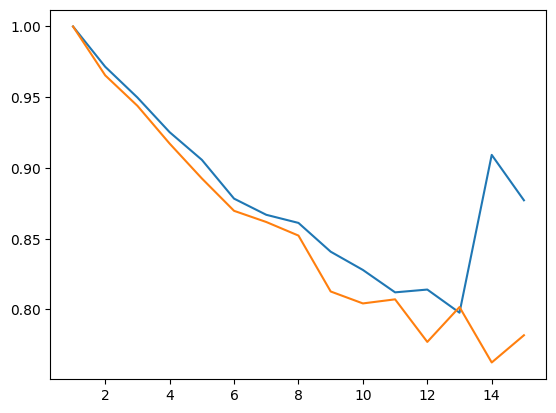

In [93]:
plt.plot(npvs3, associated3)
plt.plot(npvs4, associated4)
#plt.plot(npvs3, associated3p)
#plt.plot(npvs3, associated3m)

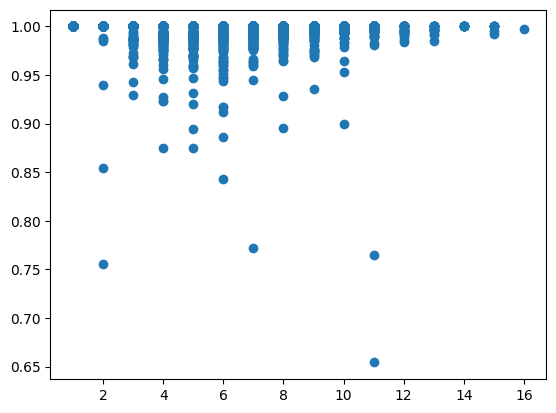

In [51]:
plt.scatter(npvs,associated)

In [30]:


running_num = 0
running_denom = 0
npvs = []
associated = []
for i, data in enumerate(val_loader):
    data.to('cuda')

    outputs = model(data)
    data = outputs
    PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)

    if b_tracks:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0][data[('tracks', 'to', 'tracks')].y[:, 0] == 0]
    else:
        tracks = data[('tracks', 'to', 'tracks')].edge_index[0]
    unique_tracks = torch.unique(tracks)
    correctly_associated = 0

    for i in unique_tracks:
        index = (data[('tracks', 'to', 'pvs')].edge_index[0] == i)
        pv_associated = (torch.argmax(
            model._blocks[-1].edge_weights[('tracks', 'to', 'pvs')][index]) == torch.argmax(
            data[('tracks', 'to', 'pvs')].y[index]))
        correctly_associated += int(pv_associated.item())
        npvs.append(data['pvs'].x.shape[0])
        associated.append( int(pv_associated.item()))
    running_num += correctly_associated 
    running_denom += unique_tracks.shape[0]
acc = running_num / running_denom


/tmp/ipykernel_25515/147940974.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PVlabel = torch.tensor(data[('tracks', 'to', 'pvs')].y, dtype=torch.float32)


In [23]:
running_num


0

In [24]:
len(val_loader)

0

In [26]:
acc

0.9762227682831331

In [31]:
acc

0.9605471940987367

In [11]:
# new computation

In [14]:
acc

0.9759243422012249

In [10]:
acc

0.9608702396649345

In [10]:
acc


0.998936743533328

In [16]:
acc


0.9987008454199954

In [28]:
acc


0.9988233818133104

In [31]:
acc


0.9980809211578442

In [32]:
acc

0.9980809211578442